In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline


#READ IN THE DATA
loan_data = pd.read_csv('C:/Users/Natasha/PycharmProjects/DataIncubator_Challenge/Data/accepted_2007_to_2018Q4.csv')


C:\Users\Natasha\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
#SIMPLIFY THE DATA
#pare down to only fully paid or charged off loans
loans = loan_data[(loan_data["loan_status"] == "Fully Paid") | (loan_data["loan_status"] == "Charged Off")]

#drop features missing >25% data
missing_data = loans.isnull().mean()
drop_list = sorted(list(missing_data[(missing_data > 0.25)].index))
loans = loans.drop(labels=drop_list, axis=1)

#drop features not available to investors, based on LCDataDictionary descriptions
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti',
             'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high',
             'fico_range_low', 'grade', 'home_ownership', 'id',
             'initial_list_status', 'installment', 'int_rate',
             'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec',
             'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util',
             'sub_grade', 'term', 'title', 'total_acc', 'verification_status',
             'zip_code']

drop_list2 = []
for col in loans.columns:
    if col not in keep_list:
        drop_list2.append(col)

loans = loans.drop(labels=drop_list2,axis=1)
#Remove NaN lines
loans = loans.dropna()

In [3]:
#MODIFY FEATURES FOR USEFULNESS
#remove " months" from term information
loans['term'] = loans['term'].apply(lambda x: x.replace(" months", ""))
loans['term'] = loans['term'].astype(int)

#change employment length year information to integers
loans['emp_length'] = loans['emp_length'].astype(str)
loans['emp_length'] = loans['emp_length'].apply(lambda x: x.replace("< 1 year","0 years").replace("1 year","1 years").replace("10+ years","10 years").replace(" years",""))
loans['emp_length'] = loans['emp_length'].astype(int)

#simplify home ownership
loans['home_ownership'] = loans['home_ownership'].apply(lambda x: x.replace('NONE','OTHER').replace('ANY','OTHER'))

#log of annual income
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

#remove outlier DTIs
loans = loans[(loans['dti'] > 0) | (loans['dti'] < 65)]

#get just year of earliest credit line
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda x: int(x[-4:]))

#average fico score
loans['fico'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']

#log of credit revolving balance
loans['log_revol_bal'] = loans['revol_bal'].apply(lambda x: np.log10(x+1))

#convert loan status to 0/1 indicator
# 0 indicates fully paid, 1 indicates charged off
loans['charged_off'] = 0
loans.loc[(loans['loan_status'] == "Charged Off"),'charged_off'] = 1

In [4]:
#KEEP ONLY USEFUL FEATURES
drop_list3 = ['id','grade','emp_title','annual_inc','title','zip_code',
              'fico_range_low','fico_range_high','revol_bal','loan_status']

loans = loans.drop(labels=drop_list3,axis=1)

In [5]:
#EXAMINE VARIABLES FOR SIGNIFICANCE
ttest_list = ['loan_amnt','term','int_rate','installment','emp_length',
              'dti','earliest_cr_line','open_acc','pub_rec','revol_util',
              'total_acc','mort_acc','pub_rec_bankruptcies','log_annual_inc',
              'fico','log_revol_bal']

t_test_results = {}
for col in ttest_list:
    group1 = loans.where(loans.charged_off == 0).dropna()[col]
    group2 = loans.where(loans.charged_off == 1).dropna()[col]
    t_test_results[col] = scipy.stats.ttest_ind(group1,group2)

ttest_df = pd.DataFrame.from_dict(t_test_results,orient='Index')
ttest_df.columns = ['statistic','pvalue']

print(ttest_df)

                       statistic         pvalue
dti                  -105.272288   0.000000e+00
revol_util            -63.782157   0.000000e+00
installment           -61.366840   0.000000e+00
term                 -202.624752   0.000000e+00
log_annual_inc         64.953802   0.000000e+00
emp_length             18.649039   1.318679e-77
log_revol_bal           7.261622   3.827060e-13
int_rate             -295.758011   0.000000e+00
earliest_cr_line      -55.168625   0.000000e+00
total_acc               9.679750   3.683027e-22
fico                  142.807722   0.000000e+00
pub_rec_bankruptcies  -25.134675  2.259586e-139
open_acc              -35.204129  2.381763e-271
mort_acc               81.781024   0.000000e+00
loan_amnt             -77.746390   0.000000e+00
pub_rec               -26.515427  7.135478e-155


In [6]:
chisq_list = ['sub_grade','home_ownership','verification_status',
              'purpose','addr_state','initial_list_status','application_type']

chi_sq_results = {}
for col in chisq_list:
    con = pd.crosstab(loans[col], loans['charged_off'])
    chi2, chi_sq_results[col], dof, exp = scipy.stats.chi2_contingency(con)

chisq_df = pd.DataFrame.from_dict(chi_sq_results,orient='Index')
chisq_df.columns = ['pvalue']

print(chisq_df)

                           pvalue
addr_state           0.000000e+00
verification_status  0.000000e+00
application_type     1.722412e-45
sub_grade            0.000000e+00
initial_list_status  2.767620e-01
purpose              0.000000e+00
home_ownership       0.000000e+00


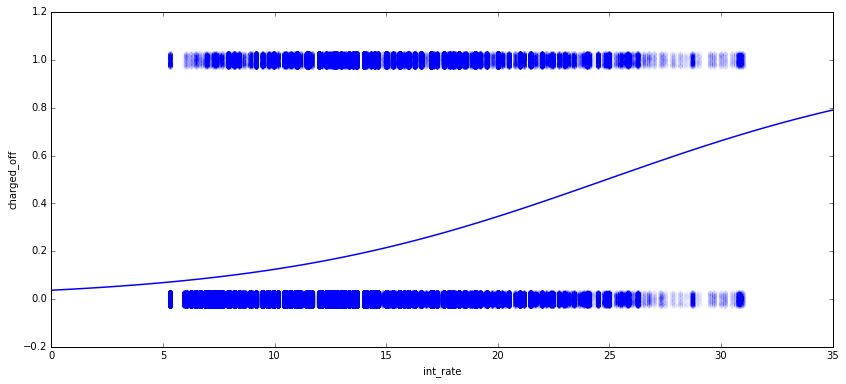

In [7]:
#VISUALIZE SOME DATA
#Interest Rate
plt.figure(figsize=(14, 6))
int_rate_plot = seaborn.regplot('int_rate','charged_off',loans,scatter=True,logistic=True,ci=None,scatter_kws={'alpha':0.002},y_jitter=.03)
plt.show(int_rate_plot)

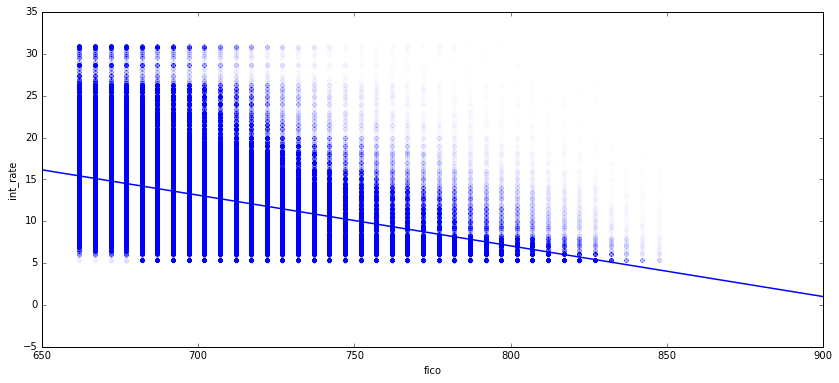

In [9]:
#Collinearity Issues

plt.figure(figsize=(14,6))
int_rate_fico_plot = seaborn.regplot('fico','int_rate',loans,scatter=True,fit_reg=True,ci=None,scatter_kws={'alpha':0.002})
plt.show(int_rate_fico_plot)